In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.linear_model import LinearRegression

In [25]:
import pandas as pd

# Load the data
users_df = pd.read_csv('users.csv')
repos_df = pd.read_csv('repositories.csv')

# Ensure created_at columns are in datetime format
users_df['created_at'] = pd.to_datetime(users_df['created_at']).dt.tz_localize(None)
repos_df['created_at'] = pd.to_datetime(repos_df['created_at']).dt.tz_localize(None)

# Calculate account age and followers growth rate
users_df['account_age_years'] = (pd.Timestamp.now() - users_df['created_at']).dt.days / 365.25
users_df['followers_growth_rate'] = users_df['followers'] / users_df['account_age_years']


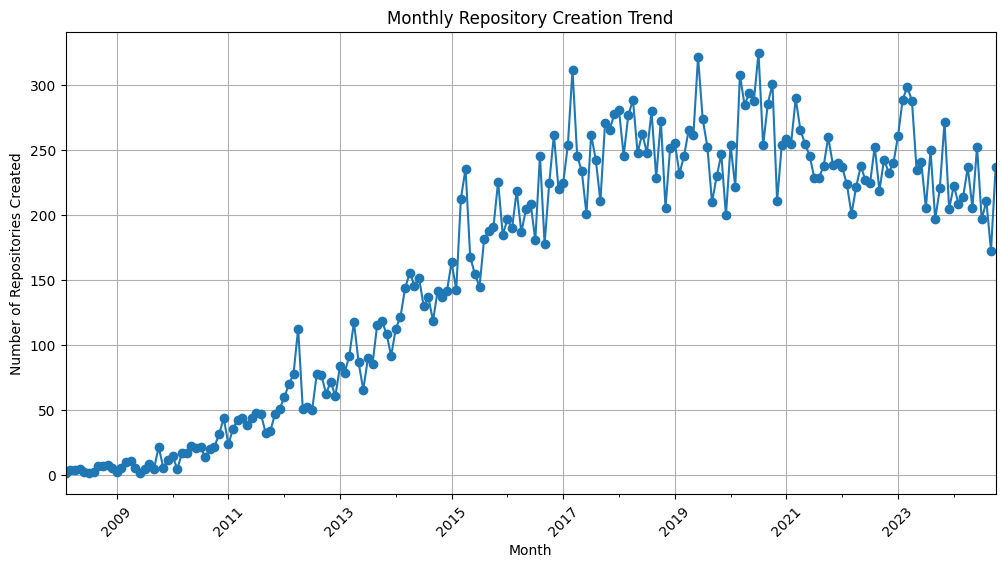

In [26]:
# Extract month from created_at
repos_df['month'] = repos_df['created_at'].dt.to_period('M')
repo_trend = repos_df.groupby('month').size()

# Plotting the trend
plt.figure(figsize=(12, 6))
repo_trend.plot(kind='line', marker='o')
plt.title('Monthly Repository Creation Trend')
plt.xlabel('Month')
plt.ylabel('Number of Repositories Created')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [27]:
# Calculate account age and followers growth rate
users_df['account_age_years'] = (pd.Timestamp.now() - users_df['created_at']).dt.days / 365.25
users_df['followers_growth_rate'] = users_df['followers'] / users_df['account_age_years']

# Top users by followers growth rate
top_growth_users = users_df.nlargest(5, 'followers_growth_rate')[['login', 'followers_growth_rate']]
top_growth_users

,login,followers_growth_rate
0,vczh,1298.543088
1,bradfitz,727.376151
2,munificent,628.584489
6,awslabs,620.517658
7,jtleek,579.496144


In [28]:

# Count repositories per user
company_repo_count = repos_df.groupby('login').size().reset_index(name='repo_count')
user_company = users_df[['login', 'company']].dropna()
merged_df = pd.merge(user_company, company_repo_count, on='login', how='inner')

# Top contributing companies
top_companies = merged_df.groupby('company')['repo_count'].sum().nlargest(5).index.tolist()
top_companies


['MICROSOFT', 'GOOGLE', 'FACEBOOK', 'UNIVERSITY OF WASHINGTON', 'AWS']

In [29]:
# Calculate language diversity
language_counts = repos_df.groupby('login')['language'].nunique().reset_index(name='language_diversity')
user_language_diversity = pd.merge(users_df[['login']], language_counts, on='login', how='left')

# Top users by language diversity
top_language_diversity_users = user_language_diversity.nlargest(5, 'language_diversity')[['login', 'language_diversity']]
top_language_diversity_users


,login,language_diversity
141,abcdabcd987,21.0
94,ingydotnet,20.0
146,spro,20.0
267,jroesch,20.0
354,cgranade,20.0


In [30]:
# Find most common phrases in bios (3-grams)
def extract_ngrams(bio, n=3):
    words = re.findall(r'\b\w+\b', bio.lower())
    ngrams = zip(*[words[i:] for i in range(n)])
    return [' '.join(gram) for gram in ngrams]

all_ngrams = []
for bio in users_df['bio'].dropna():
    all_ngrams.extend(extract_ngrams(bio))

# Count occurrences of each n-gram
ngram_counts = Counter(all_ngrams)
top_ngrams = ngram_counts.most_common(5)
top_ngrams


[('7 7 7', 8),
 ('research scientist at', 5),
 ('university of washington', 5),
 ('i have a', 5),
 ('have a joke', 5)]

Topic Modeling of User Bios
Objective: Discover common topics among users based on their bios using Latent Dirichlet Allocation (LDA).



In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Prepare the data for LDA
vectorizer = CountVectorizer(stop_words='english')
bio_matrix = vectorizer.fit_transform(users_df['bio'].fillna(''))

# Fit LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(bio_matrix)

# Display topics
for index, topic in enumerate(lda.components_):
    print(f"Topic {index}:")
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]]))


Topic 0:
tech web developer founder code
Topic 1:
scientist engineer microsoft ai research
Topic 2:
net developer engineer aws data
Topic 3:
learning microsoft building engineer software
Topic 4:
team manager principal microsoft developer


In [38]:
# Check if 'created_at' column exists
if 'created_at' in repos_df.columns:
    # Convert 'created_at' to datetime
    repos_df['created_at'] = pd.to_datetime(repos_df['created_at'])

    # Extract month and day of the week
    repos_df['month'] = repos_df['created_at'].dt.month_name()
    repos_df['day_of_week'] = repos_df['created_at'].dt.day_name()

    # Count repositories created by month
    monthly_counts = repos_df['month'].value_counts().sort_index()

    # Count repositories created by day of the week
    weekly_counts = repos_df['day_of_week'].value_counts().sort_index()

    print("Monthly Repository Creation Counts:\n", monthly_counts)
    print("Weekly Repository Creation Counts:\n", weekly_counts)
else:
    print("No 'created_at' column found in repos_df.")


Monthly Repository Creation Counts:
 month
April        2985
August       2775
December     2482
February     2584
January      2656
July         2639
June         2746
March        2967
May          2702
November     2573
October      2861
September    2506
Name: count, dtype: int64
Weekly Repository Creation Counts:
 day_of_week
Friday       4971
Monday       4806
Saturday     3362
Sunday       3100
Thursday     5400
Tuesday      5360
Wednesday    5477
Name: count, dtype: int64
